# 这是我的第一个集成模型

简单起见，我们使用小的数据集和两个小的模型集成

## 导入需要的包

In [1]:
import tensorflow as tf
import pathlib
import random

使用pathlib.Path来获取图片的地址

In [2]:
data_root_orig = r'C:\Users\Administrator\Desktop\flower_photos'
data_root = pathlib.Path(data_root_orig)



all_image_paths = list(data_root.glob('*/*.jpg'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)
all_image_paths[:5]

['C:\\Users\\Administrator\\Desktop\\flower_photos\\tulips\\6989946990_62c639ff16_n.jpg',
 'C:\\Users\\Administrator\\Desktop\\flower_photos\\tulips\\130684941_d1abfa3be6_m.jpg',
 'C:\\Users\\Administrator\\Desktop\\flower_photos\\daisy\\4657354814_f368762c53_m.jpg',
 'C:\\Users\\Administrator\\Desktop\\flower_photos\\tulips\\113960470_38fab8f2fb_m.jpg',
 'C:\\Users\\Administrator\\Desktop\\flower_photos\\roses\\3171577977_8608282f04_m.jpg']

在获取图片的标签名字

In [3]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names.remove('.ipynb_checkpoints')
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

再将标签名字，生成字典label_to_index

In [4]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

将图片对应的路径映射成标签

In [5]:
all_image_labels = [label_to_index.get(pathlib.Path(path).parent.name)
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [4, 4, 0, 4, 2, 3, 2, 0, 3, 1]


看一下样本的数量

In [6]:
length = len(all_image_labels)

将数据分成两份，训练数据与验证数据

In [7]:
index = tf.range(length)
index = tf.random.shuffle(index)
train_image_paths = tf.gather(all_image_paths, index[:3000])
train_image_labels = tf.gather(all_image_labels, index[:3000])
test_image_paths = tf.gather(all_image_paths, index[3000:])
test_image_labels = tf.gather(all_image_labels, index[3000:])

## 建立数据集

掉用tf.data.Dataset.from_tensor_slices命令，创建train_ds和test_ds

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_image_labels))
print(train_ds)
print(test_ds)

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>
<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>


写一个预处理函数，将x（路径）映射成Tensor，

In [9]:
def preprocessing(x, y):
    x = tf.io.read_file(x)# img_raw
    x = tf.image.decode_jpeg(x, channels=3)
    x = tf.image.resize(x, [128, 128])
    x = (x / 255.0) * 2 - 1  # normalize to [-1,1] range
    x = tf.cast(x, dtype=tf.float32)
    
    y = tf.cast(y, dtype=tf.int32)
    return x, y

将数据集的小批量大小设置好

In [10]:
batch_size = 128
train_ds = train_ds.map(preprocessing).batch(batch_size,drop_remainder=True)
test_ds = test_ds.map(preprocessing).batch(batch_size,drop_remainder=True)
print(train_ds)
test_ds

<BatchDataset shapes: ((128, 128, 128, 3), (128,)), types: (tf.float32, tf.int32)>


<BatchDataset shapes: ((128, 128, 128, 3), (128,)), types: (tf.float32, tf.int32)>

## 定义模型

简单的两个模型集成的模型

In [11]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu',)
        self.drop1 = tf.keras.layers.Dropout(0.8)
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(128, activation='relu')
        self.drop2 = tf.keras.layers.Dropout(0.8)
        self.d2 = tf.keras.layers.Dense(5)
        
        self.flatten_2 = tf.keras.layers.Flatten()
        self.d1_2 = tf.keras.layers.Dense(128*4, activation='relu')
        self.drop1_2 = tf.keras.layers.Dropout(0.8)
        self.d2_2 = tf.keras.layers.Dense(128, activation='relu')
        self.drop2_2 = tf.keras.layers.Dropout(0.8)
        self.d3_2 = tf.keras.layers.Dense(5)

    def call(self, x, training=None):
        x_1 = self.conv1(x)
        x_1 = self.drop1(x_1, training=training)
        x_1 = self.flatten(x_1)
        x_1 = self.d1(x_1)
        x_1 = self.drop2(x_1, training=training)
        logit_1 = self.d2(x_1)
        
        x_2 = self.flatten_2(x)
        x_2 = self.d1_2(x_2)
        x_2 = self.drop1_2(x_2, training=training)
        x_2 = self.d2_2(x_2)
        x_2 = self.drop2_2(x_2, training=training)
        logit_2 = self.d3_2(x_2)
        
        logit = tf.add(logit_1, logit_2) / 2
        return logit

# Create an instance of the model
model = MyModel()

# 定义损失函数和优化器

y_pred为N维向量（N为类别的个数），label为单个数字，如果label也是one-hot之后的值，需要使用CategoricalCrossentropy损失函数。

In [12]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

下面是评估的指标的定义

In [13]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

训练步函数的定义，使用@tf.function装饰器，将之转换成图，以便加速

In [14]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

同样的定义验证步函数

In [15]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

## 训练模型

In [16]:
EPOCHS = 50
history_train_loss = []
history_train_accuracy = []
history_test_loss = []
history_test_accuracy = []
for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    history_train_loss.append(train_loss.result().numpy())
    history_train_accuracy.append(train_accuracy.result().numpy())
    history_test_loss.append(test_loss.result().numpy())
    history_test_accuracy.append(test_accuracy.result().numpy())
    print(
      f'Epoch {epoch + 1}, '
      f'Loss: {train_loss.result()}, '
      f'Accuracy: {train_accuracy.result() * 100}, '
      f'Test Loss: {test_loss.result()}, '
      f'Test Accuracy: {test_accuracy.result() * 100}'
    )

Epoch 1, Loss: 23.672330856323242, Accuracy: 25.169837951660156, Test Loss: 2.731343984603882, Test Accuracy: 46.09375
Epoch 2, Loss: 10.782574653625488, Accuracy: 26.936140060424805, Test Loss: 2.114260673522949, Test Accuracy: 44.0625
Epoch 3, Loss: 7.077371120452881, Accuracy: 28.770381927490234, Test Loss: 1.5728152990341187, Test Accuracy: 42.1875
Epoch 4, Loss: 5.978082180023193, Accuracy: 28.804346084594727, Test Loss: 1.5461289882659912, Test Accuracy: 48.75
Epoch 5, Loss: 4.393439769744873, Accuracy: 31.589675903320312, Test Loss: 1.3460538387298584, Test Accuracy: 52.65625
Epoch 6, Loss: 3.693207025527954, Accuracy: 33.22010803222656, Test Loss: 1.339282751083374, Test Accuracy: 48.90625
Epoch 7, Loss: 3.036271572113037, Accuracy: 30.944293975830078, Test Loss: 1.294676423072815, Test Accuracy: 53.281246185302734
Epoch 8, Loss: 2.6416122913360596, Accuracy: 34.00135803222656, Test Loss: 1.2876040935516357, Test Accuracy: 50.625003814697266
Epoch 9, Loss: 2.520601511001587, Ac

## 将训练过程中的评价指标画出来

简单定义一个画图的函数

In [17]:
import matplotlib.pyplot as plt
def plot_graph(x,y):
    plt.plot(x)
    plt.plot(y)
    plt.show()

将训练与验证损失的曲线画出

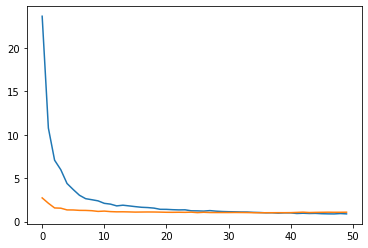

In [18]:
plot_graph(history_train_loss,history_test_loss)

将训练与验证正确率的曲线画出来

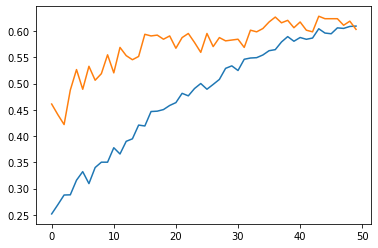

In [19]:
plot_graph(history_train_accuracy, history_test_accuracy)